# Surface Circulation — NEMO GYRE

Analyse surface currents from the 2-year GYRE simulation.
- Surface current vectors
- Surface kinetic energy

In [1]:
from pathlib import Path

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import xarray as xr

OUTPUT_DIR = Path("../output")

ds_u = xr.open_dataset(
    OUTPUT_DIR / "GYRE_10d_00010101_00021230_grid_U_0000.nc", decode_times=False
)
ds_v = xr.open_dataset(
    OUTPUT_DIR / "GYRE_10d_00010101_00021230_grid_V_0000.nc", decode_times=False
)
ds_t = xr.open_dataset(
    OUTPUT_DIR / "GYRE_10d_00010101_00021230_grid_T_0000.nc", decode_times=False
)
mask = xr.open_dataset(OUTPUT_DIR / "mesh_mask.nc")
tmask_sfc = mask["tmask"].isel(time_counter=0, nav_lev=0).values

# Grid rotation angle: GYRE grid i-axis is rotated 45° from east
# Compute from glamt/gphit to be explicit
glamt = mask["glamt"].isel(time_counter=0).values
gphit = mask["gphit"].isel(time_counter=0).values
dx_lon = np.diff(glamt, axis=1)
dx_lat = np.diff(gphit, axis=1)
# Pad to original shape (repeat last column)
dx_lon = np.concatenate([dx_lon, dx_lon[:, -1:]], axis=1)
dx_lat = np.concatenate([dx_lat, dx_lat[:, -1:]], axis=1)
grid_angle = np.arctan2(dx_lat, dx_lon)  # angle of i-axis from east

def rotate_to_geo(ui, vj, angle):
    """Rotate (i,j)-aligned vectors to geographic (east, north)."""
    cos_a = np.cos(angle)
    sin_a = np.sin(angle)
    u_east  = ui * cos_a - vj * sin_a
    v_north = ui * sin_a + vj * cos_a
    return u_east, v_north

# Exclude 2-cell border for velocities (staggered grid boundary effects)
interior = tmask_sfc.copy()
interior[:2, :] = 0
interior[-2:, :] = 0
interior[:, :2] = 0
interior[:, -2:] = 0

# Map projection centred on the GYRE domain
MARGIN = 4
lon, lat = ds_t.nav_lon.values, ds_t.nav_lat.values
proj = ccrs.Stereographic(central_longitude=-68, central_latitude=32)
extent = [lon.min() - MARGIN, lon.max() + MARGIN,
          lat.min() - MARGIN, lat.max() + MARGIN]

# Surface level (index 0) time-mean velocities
u_sfc = ds_u["vozocrtx"].isel(depthu=0).mean("time_counter")
v_sfc = ds_v["vomecrty"].isel(depthv=0).mean("time_counter")

print(f"U shape: {u_sfc.shape}, V shape: {v_sfc.shape}")
print(f"Grid angle: {np.degrees(grid_angle[10, 15]):.1f}°")

U shape: (22, 32), V shape: (22, 32)
Grid angle: 45.0°


## Surface current vectors

Time-mean surface velocity field. The quiver plot should show the
double-gyre pattern: subtropical anticyclonic gyre in the south,
subpolar cyclonic gyre in the north, with a strong western boundary
current.

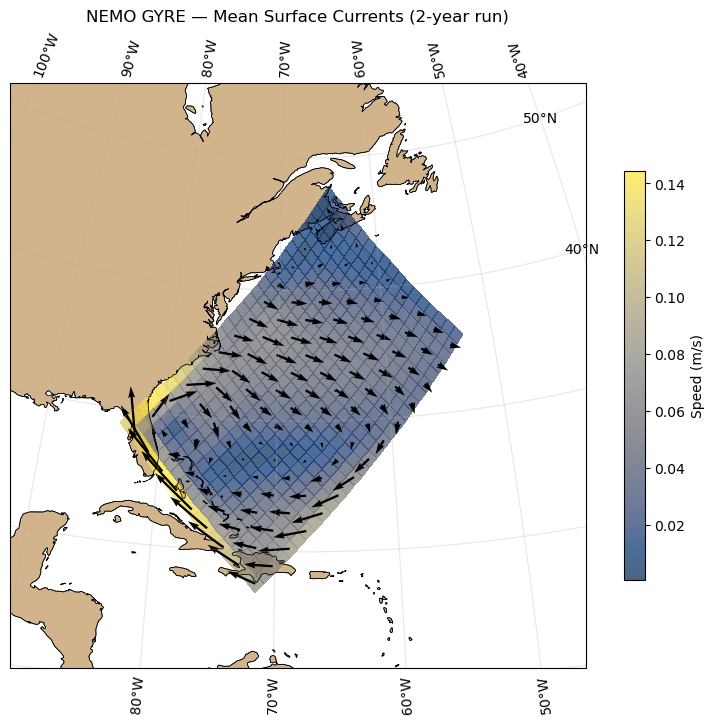

In [2]:
ny, nx = min(u_sfc.shape[0], v_sfc.shape[0]), min(u_sfc.shape[1], v_sfc.shape[1])
u_i = u_sfc.values[:ny, :nx]
v_j = v_sfc.values[:ny, :nx]
lo = lon[:ny, :nx]
la = lat[:ny, :nx]
im = interior[:ny, :nx]
ga = grid_angle[:ny, :nx]

# Rotate from grid (i,j) to geographic (east, north)
u_east, v_north = rotate_to_geo(u_i, v_j, ga)

speed = np.sqrt(u_east**2 + v_north**2)
speed_masked = np.where(im, speed, np.nan)

fig, ax = plt.subplots(figsize=(8, 7), subplot_kw=dict(projection=proj))
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor="tan", edgecolor="k", linewidth=0.5)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.gridlines(draw_labels=True, alpha=0.3)

pcm = ax.pcolormesh(
    lo, la, speed_masked,
    shading="auto", cmap="cividis", alpha=0.7, transform=ccrs.PlateCarree(),
)
fig.colorbar(pcm, ax=ax, label="Speed (m/s)", shrink=0.7)

skip = 2
ax.quiver(
    lo[::skip, ::skip], la[::skip, ::skip],
    np.where(im[::skip, ::skip], u_east[::skip, ::skip], np.nan),
    np.where(im[::skip, ::skip], v_north[::skip, ::skip], np.nan),
    color="k", scale=1.5, width=0.004, transform=ccrs.PlateCarree(),
)
ax.set_title("NEMO GYRE — Mean Surface Currents (2-year run)")
fig.tight_layout()

## Surface kinetic energy

Time-mean surface KE = 0.5 (u² + v²). Highlights the energetic
western boundary current and inter-gyre jet.

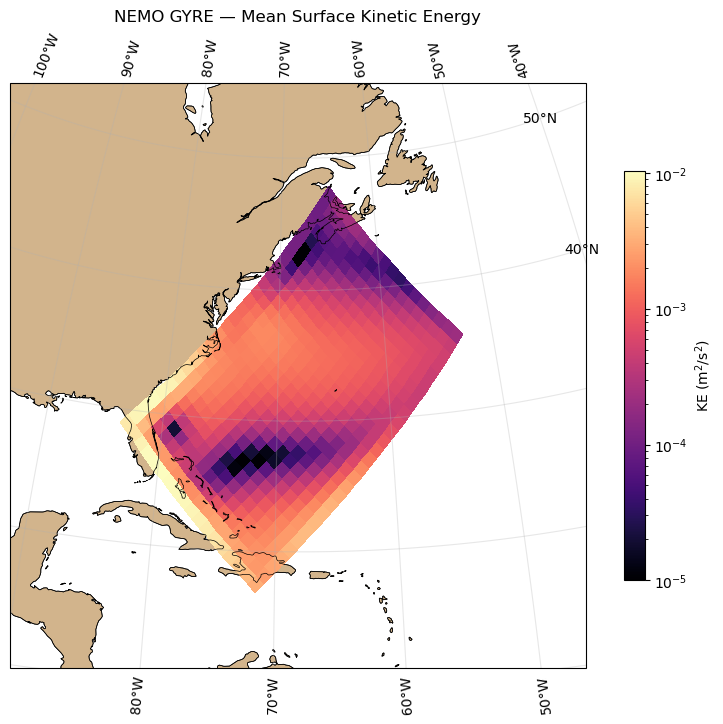

In [3]:
ke = 0.5 * speed**2
ke_masked = np.where(im, ke, np.nan)

fig, ax = plt.subplots(figsize=(8, 7), subplot_kw=dict(projection=proj))
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor="tan", edgecolor="k", linewidth=0.5)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.gridlines(draw_labels=True, alpha=0.3)

pcm = ax.pcolormesh(
    lo, la, ke_masked, shading="auto", cmap="magma",
    norm=mcolors.LogNorm(vmin=1e-5, vmax=ke_masked[np.isfinite(ke_masked)].max()),
    transform=ccrs.PlateCarree(),
)
fig.colorbar(pcm, ax=ax, label="KE (m$^2$/s$^2$)", shrink=0.7)
ax.set_title("NEMO GYRE — Mean Surface Kinetic Energy")
fig.tight_layout()